# LSTM Autoencoder - Basic Example

Here, in this notebook, we shall see how to create a basic LSTM Autoencoder. For the dataset, we have used the ECG 5000 dataset as datasource. 

**NOTE: HERE since the ECG dataset is a function of time, using LSTM is the viable option.**

In [1]:
import torch.nn as nn
import torch
from torch.nn.modules.container import Sequential
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime
from sklearn.preprocessing import StandardScaler
from arff2pandas import a2p

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
pass

## Loading or Formulating the dataset

The Dataset available on the web is in some weird format, I have created a CSV out of it so to make it less intimidating to handle. So we just have to load the csv file.

The idea here is to train the Autoencoder to understand the normal heartbeats pattern so in case of any anamoly it'll raise a flag. To do that, we need to filter out the `target` with the value of `1` as it represents the normal heartbeat pattern.



In [10]:
df = pd.read_csv('D:\Dataset\ECG5000\ecg5000_dataset.csv')

In [11]:
df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1


In [14]:
normal_df = df[df['target'] == 1].drop('target', axis=1)

In [15]:
normal_df.shape

(2919, 140)

Now, we have around `2919` normal samples. So we'll take `2000` for training the autoencoder and rest `919` for testing.

In [16]:
train_df = normal_df.iloc[:2000]
test_df = normal_df.iloc[2000:]

Next, we would need to convert the train and test dataframes to tensor and unsqueeze them to a single array format, like 

$[1,2,3,4,5]$

$[6,7,8,9,10]$

to the format

$[[[1],$

$ [2] $

$ [3] $

$ [4] $

$ [5]], $

$ [[6],$

$ [7] $

$ [8] $

$ [9] $

$ [10]]] $

In [17]:
X_train = train_df.iloc[:,:].values
x_test = test_df.iloc[:,:].values

In [18]:
X_train_tensor = [torch.tensor(s).unsqueeze(1).float() for s in X_train]
X_test_tensor = [torch.tensor(s).unsqueeze(1).float() for s in x_test]

In [20]:
X_train_tensor[0]

tensor([[-0.1125],
        [-2.8272],
        [-3.7739],
        [-4.3498],
        [-4.3760],
        [-3.4750],
        [-2.1814],
        [-1.8183],
        [-1.2505],
        [-0.4775],
        [-0.3638],
        [-0.4920],
        [-0.4219],
        [-0.3092],
        [-0.4959],
        [-0.3421],
        [-0.3553],
        [-0.3679],
        [-0.3165],
        [-0.4124],
        [-0.4717],
        [-0.4135],
        [-0.3646],
        [-0.4493],
        [-0.4714],
        [-0.4248],
        [-0.4625],
        [-0.5525],
        [-0.4754],
        [-0.6942],
        [-0.7019],
        [-0.5938],
        [-0.6607],
        [-0.7138],
        [-0.7698],
        [-0.6723],
        [-0.6537],
        [-0.6394],
        [-0.5593],
        [-0.5917],
        [-0.4932],
        [-0.4631],
        [-0.3016],
        [-0.2327],
        [-0.1251],
        [-0.1539],
        [-0.0244],
        [-0.0656],
        [ 0.0350],
        [ 0.0619],
        [ 0.0712],
        [ 0.1239],
        [ 0.

## Modelling

![image info](../images/autoencoder_architecture.png)

### **Encoder**

The first part of the an **AutoEncoder** model is the **Encoder**. The Encoder would take a the sequence of length $140$ in this case (as our ECG dataset has $140$ timesteps in single row/value) and layer by layer, it will reduce the size of the to $128$ in the end.

In [21]:

class EncoderNN(nn.Module):

    def __init__(self):
        super(EncoderNN, self).__init__()

        self.batch = 1
        self.num_of_layers = 1
        self.number_of_features = 1
        self.input_layer_size = 140        
        self.latent_vector_dimension = 128
        self.hidden_layer_size = 2 * self.latent_vector_dimension

        self.lstm1 = nn.LSTM(self.number_of_features, self.hidden_layer_size, self.num_of_layers, batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_layer_size, self.latent_vector_dimension, self.num_of_layers, batch_first=True)


    def forward(self, x):

        x = x.reshape((self.batch, self.input_layer_size, self.number_of_features))

        x, (hidden_state, cell_state) = self.lstm1(x)
        x, (hidden_state, cell_state) = self.lstm2(x)

        last_lstm_layer_hidden_state = hidden_state.reshape((self.num_of_layers *self.number_of_features, self.latent_vector_dimension))

        return last_lstm_layer_hidden_state

### **Decoder**

The second part of the an **AutoEncoder** model is the **Decoder**. The Decoder would take it from where Encoder finishes. The Decoder would take the $128$ sequence length here in this case and layer by layer it will increase the size from $128$ to $140$ in the end.

So the Decoder again reconstructs the data to the same number of data points form where the Encoder started. We will then use this reconstructed data, compare it with the original data and calculate the $MSE$. The whole idea is to try reduce this error.

In [22]:
class DecoderNN(nn.Module):

    def __init__(self):
        super(DecoderNN, self).__init__()

        self.batch = 1

        self.num_of_layers = 1

        self.number_of_features = 1
        self.input_layer_size = 140
        self.latent_vector_dimension = 128
        self.hidden_layer_size = 2 * self.latent_vector_dimension
        

        self.lstm1 = nn.LSTM(self.num_of_layers * self.latent_vector_dimension, self.latent_vector_dimension, self.num_of_layers, batch_first=True)
        self.lstm2 = nn.LSTM(self.latent_vector_dimension, self.hidden_layer_size, self.num_of_layers, batch_first=True)

        self.output_layer = nn.Linear(self.hidden_layer_size, self.number_of_features)

    def forward(self, x):
        x = x.repeat(self.input_layer_size, self.batch)
        # print(x.shape)
        x = x.reshape((self.number_of_features, self.input_layer_size, self.latent_vector_dimension * self.num_of_layers))
        # print(x.sha
        x, (hidden_state, cell_state) = self.lstm1(x)
        x, (hidden_state, cell_state) = self.lstm2(x)

        x = x.reshape((self.input_layer_size, self.hidden_layer_size))

        return self.output_layer(x)

In [23]:
class AutoencoderNN(nn.Module):

  def __init__(self):
    super(AutoencoderNN,self).__init__()
    
    self.encoder = EncoderNN().to(device)
    self.decoder = DecoderNN().to(device)


  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [24]:
model = AutoencoderNN().to(device)
print(model)

AutoencoderNN(
  (encoder): EncoderNN(
    (lstm1): LSTM(1, 256, batch_first=True)
    (lstm2): LSTM(256, 128, batch_first=True)
  )
  (decoder): DecoderNN(
    (lstm1): LSTM(128, 128, batch_first=True)
    (lstm2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [25]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
epochs = 30

previous_low_mse = 0

current_loss = 0

running_loss_history = []
epoch_list = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for epoch in range(epochs):

    es = time.time()

    model.train()

    val_running_loss = 0.0
    running_loss = 0.0

    # See we're not using any labels here.

    for inputs in X_train_tensor:

        inputs = inputs.to(device)

        optimizer.zero_grad()

        output = model(inputs)

        # Compairing the output with the input and not the labels
        loss = criterion(output, inputs)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    else:
        model.eval()
        with torch.no_grad():
            for val_inputs in X_test_tensor:

                val_inputs = val_inputs.to(device)

                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_inputs)

                current_loss = val_loss

                val_running_loss += val_loss.item()

    
    if previous_low_mse < current_loss:
        torch.save(model.state_dict(), 'D:\Dataset\ECG5000\model.pth')
        print("\nSaved the best model.\n")

    previous_low_mse = current_loss
    
    epoch_loss = running_loss/len(X_train_tensor)
    running_loss_history.append(epoch_loss)

    val_epoch_loss = val_running_loss/ len(X_test_tensor)
    val_running_loss_history.append(val_epoch_loss)

    epoch_list.append(epoch + 1)

    

    ee = time.time()

    print("Epoch : ",epoch + 1)
    print('training loss: {:.4f}'.format(running_loss/len(X_train_tensor)))
    print('validation loss: {:.4f}'.format(val_epoch_loss))
    print("Time Elapsed : ",round(ee-es,2))
    print('_'*20)


Saved the best model.

Epoch :  1
training loss: 0.3265
validation loss: 0.3058
Time Elapsed :  113.99
____________________

Saved the best model.

Epoch :  2
training loss: 0.2973
validation loss: 0.2847
Time Elapsed :  114.91
____________________

Saved the best model.

Epoch :  3
training loss: 0.3179
validation loss: 0.3032
Time Elapsed :  119.27
____________________

Saved the best model.

Epoch :  4
training loss: 0.3318
validation loss: 0.3267
Time Elapsed :  130.83
____________________
Epoch :  5
training loss: 0.3281
validation loss: 0.3103
Time Elapsed :  129.78
____________________
Epoch :  6
training loss: 0.2603
validation loss: 0.2481
Time Elapsed :  131.37
____________________
Epoch :  7
training loss: 0.2179
validation loss: 0.1918
Time Elapsed :  130.79
____________________
Epoch :  8
training loss: 0.2000
validation loss: 0.1759
Time Elapsed :  130.8
____________________
Epoch :  9
training loss: 0.1708
validation loss: 0.1356
Time Elapsed :  130.54
_________________

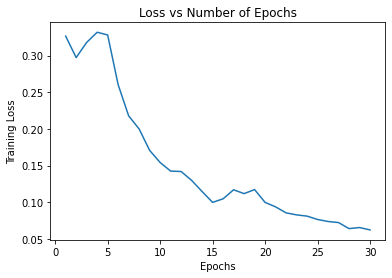

In [28]:
plt.plot(epoch_list,running_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Loss vs Number of Epochs")
plt.show()

In [29]:
def predict(model, dataset):
    predictiones, losses = [], []
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictiones.append(seq_pred.cpu().numpy().flatten())

            losses.append(loss.item())

    return predictiones, losses

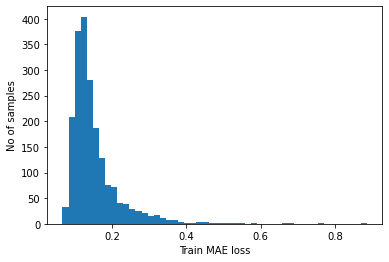

Reconstruction error threshold:  0.8862519308557366


In [30]:
x_train_pred, _ = predict(model, X_train_tensor)

train_mae_loss = np.mean(np.abs(x_train_pred - X_train[:2000]), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

Here, since we know that every row represents a ECG series, so we can try plotting it and see the results. Both the prediction and the actual data should represent a approximately same ECG series.

In [31]:
x_test_pred, pred_losses = predict(model, X_test_tensor)

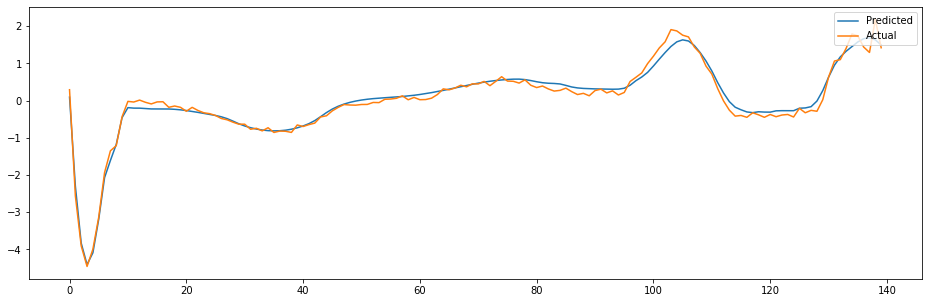

In [32]:
plt.figure(figsize=(16,5))
plt.plot(x_test_pred[41], label="Predicted")
plt.plot(X_test_tensor[41].detach().tolist(), label="Actual")
plt.legend(loc='upper right')
plt.show()

Noe let's check how abnormality looks like with this AE model

In [33]:
abnormal_df = df[df['target'] != 1].drop('target', axis=1)

In [34]:
abnormal_df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC
292,-0.032245,-0.545050,-0.822340,-1.605085,-1.805775,-2.008067,-2.233975,-2.191458,-2.058071,-1.880849,...,-0.906425,-1.621376,-2.329090,-3.049894,-3.620413,-4.210482,-4.043785,-3.051813,-2.806866,-0.879666
293,-0.003377,-0.279265,-0.230519,-0.635978,-0.894795,-1.023105,-1.243738,-1.458372,-1.677896,-1.784529,...,-2.155969,-2.640508,-3.218384,-3.651630,-3.881198,-3.924672,-3.164390,-2.228373,-1.837544,-0.378489
294,0.195989,-0.222258,-0.754773,-1.415614,-1.775851,-2.162326,-2.467492,-2.331384,-1.993476,-1.611709,...,-0.162438,-0.935030,-1.654340,-2.434240,-3.472170,-4.280780,-4.629438,-3.794192,-2.851468,-1.743521
295,0.894867,-0.003822,-0.751052,-1.396543,-1.737838,-2.113020,-2.213210,-2.203347,-2.024191,-1.591458,...,-0.899746,-1.441516,-1.861612,-2.321381,-2.884877,-3.530246,-4.412515,-3.903331,-3.567106,-1.536338
296,1.250060,0.760800,0.042925,-0.627974,-0.963454,-1.261335,-1.652440,-1.888433,-1.935217,-1.808429,...,-0.695282,-0.979223,-1.353969,-1.952051,-2.640386,-3.000281,-3.812490,-3.973360,-5.221946,-3.661793


In [35]:
abnormal_test = abnormal_df.iloc[:,:].values
abnormal_test_tensor = [torch.tensor(s).unsqueeze(1).float() for s in abnormal_test]

In [36]:
abnormal_test_pred, _ = predict(model, abnormal_test_tensor)

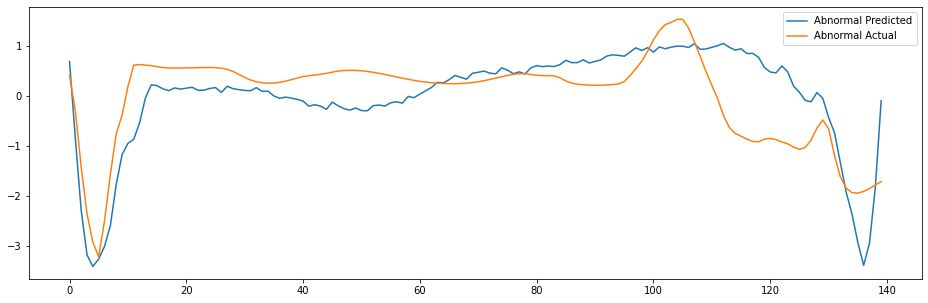

In [38]:
plt.figure(figsize=(16,5))
plt.plot(abnormal_test[41], label="Abnormal Predicted")
plt.plot(abnormal_test_pred[41], label="Abnormal Actual")
plt.legend(loc='upper right')
plt.show()

**Conclusion : We see there is a lot of difference between the Actual ECG and the Predicted one, so we consider this ECG data as abnormal.**